# MIMICIII Data Experiment - Combined notes
<p>#TODO: Needs description of what this file is</p>

# Initialize environment

In [1]:
import sys
import os

WORKING_DIR = f'{os.getcwd()}' 
MAGRITTE_DIR = f'{WORKING_DIR}/../../magritte'
UTILITIES_DIR = f'{MAGRITTE_DIR}/utilities'

DATA_DIR = f'{WORKING_DIR}/../../data/mimiciii/working'

# Add the UTILITY_DIR to the path to import files
sys.path.append(UTILITIES_DIR)


print(f'Environment configured:')
print(f'WORKING_DIR:   {WORKING_DIR}')
print(f'MAGRITTE_DIR:  {MAGRITTE_DIR}')
print(f'UTILITIES_DIR: {UTILITIES_DIR}')
print(f'DATA_DIR:      {DATA_DIR}')


Environment configured:
WORKING_DIR:   /home/magni/ML_Root/project_root/mimic-iii_LL/notebooks
MAGRITTE_DIR:  /home/magni/ML_Root/project_root/mimic-iii_LL/notebooks/../../magritte
UTILITIES_DIR: /home/magni/ML_Root/project_root/mimic-iii_LL/notebooks/../../magritte/utilities
DATA_DIR:      /home/magni/ML_Root/project_root/mimic-iii_LL/notebooks/../../data/mimiciii/working


In [2]:
import pandas as pd
import pickle
import DataUtils
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from DataPackage import DataPackage
from ExperimentManager import ExperimentManager
from TensorParameters import TensorParms
import tensorflow as tf

# Load Data
<p>Loading the MIMIC Dataset (Combined)<br>


In [3]:
# Loading the mimic-iii "combined" Dataset
ORIG_DF = pd.read_pickle(f'{DATA_DIR}/notes_combined.pkl.gz')

DataUtils.exploreDataframe(ORIG_DF)

dataframe shape: (58328, 6)

dataframe info: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 58328 entries, 0 to 58327
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   HADM_ID     58328 non-null  float64
 1   TEXT        58328 non-null  object 
 2   ROW_ID      58328 non-null  int64  
 3   SUBJECT_ID  58328 non-null  int64  
 4   SEQ_NUM     58328 non-null  float64
 5   ICD9_CODE   58328 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 3.1+ MB
None

Null value count by column:


HADM_ID       0
TEXT          0
ROW_ID        0
SUBJECT_ID    0
SEQ_NUM       0
ICD9_CODE     0
dtype: int64



First 5 in dataframe


,HADM_ID,TEXT,ROW_ID,SUBJECT_ID,SEQ_NUM,ICD9_CODE
0,100001.0,Admission Date: [**2117-9-11**] ...,464704,58526,1.0,25013
1,100003.0,Admission Date: [**2150-4-17**] ...,446055,54610,1.0,53100
2,100006.0,Admission Date: [**2108-4-6**] Discharg...,110907,9895,1.0,49320
3,100007.0,Admission Date: [**2145-3-31**] ...,256425,23018,1.0,56081
4,100009.0,Admission Date: [**2162-5-16**] ...,6306,533,1.0,41401



Last 5 in dataframe


,HADM_ID,TEXT,ROW_ID,SUBJECT_ID,SEQ_NUM,ICD9_CODE
58323,199993.0,Admission Date: [**2161-10-23**] Discha...,232053,20785,1.0,41031
58324,199994.0,Admission Date: [**2188-7-7**] Discharg...,265424,23761,1.0,486
58325,199995.0,Admission Date: [**2137-12-11**] Discha...,216925,19412,1.0,4210
58326,199998.0,Admission Date: [**2119-2-18**] ...,305582,27200,1.0,41401
58327,199999.0,Admission Date: [**2136-4-4**] D...,380657,40370,1.0,48284


In [4]:
# Setting up variables for later usage in DataPackage
DATA_COLUMN = 'TEXT'
TARGET_COLUMN = 'ICD9_CODE'
UNIQUE_COLUMN = None   # Unique index column. If None, one will be created

In [5]:
# Code frequency distribution for data frame

# ADDING a variable to be used for kMeans clustering later
NUM_UNIQUE_ICD9_CODES=4

topICD_codes, bottomICD_codesList = DataUtils.showUniqueColVals(ORIG_DF, colName='ICD9_CODE', showRecords=NUM_UNIQUE_ICD9_CODES)

Data type of column [ICD9_CODE] is: object
Total number of rows: 58328
Unique values in column: 2769 [percent unique: 4.7%]
Null values in column: 0
List of unique values:
['25013' '53100' '49320' ... '6141' '6398' '88121']

Top 4 records by frequency for ICD9_CODE
     ICD9_CODE  record_count
833      41401          3497
2731     V3000          3427
2732     V3001          2695
47        0389          2043

Bottom 4 records by frequency for ICD9_CODE
     ICD9_CODE  record_count
2768     V7281             1
577      28411             1
598      28749             1
603      28802             1


In [6]:
# Filter records for top ICD9_CODE
ORIG_DF_filtered = ORIG_DF.loc[ORIG_DF['ICD9_CODE'].isin(topICD_codes)]

# Filter records for only the columns we need
ORIG_DF_filtered = ORIG_DF_filtered[[DATA_COLUMN, TARGET_COLUMN]]

# Check columns
DataUtils.exploreDataframe(ORIG_DF_filtered)

dataframe shape: (11662, 2)

dataframe info: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11662 entries, 4 to 58326
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   TEXT       11662 non-null  object
 1   ICD9_CODE  11662 non-null  object
dtypes: object(2)
memory usage: 273.3+ KB
None

Null value count by column:


TEXT         0
ICD9_CODE    0
dtype: int64



First 5 in dataframe


,TEXT,ICD9_CODE
4,Admission Date: [**2162-5-16**] ...,41401
7,Admission Date: [**2177-3-12**] ...,41401
14,Neonatology\nPatient is term infant sent to NI...,V3000
15,Admission Date: [**2170-9-19**] ...,41401
16,Admission Date: [**2191-7-13**] Dischar...,V3000



Last 5 in dataframe


,TEXT,ICD9_CODE
58293,Admission Date: [**2194-2-4**] D...,0389
58294,Admission Date: [**2109-6-21**] ...,41401
58299,Newborn Med Attending\n\nAsked by Dr [**Last N...,V3000
58314,Neonatology NP Triage Note\nThis is a full ter...,V3000
58326,Admission Date: [**2119-2-18**] ...,41401


In [7]:
# Check results of filtering
topICD_codes, bottomICD_codesList = DataUtils.showUniqueColVals(ORIG_DF_filtered, colName='ICD9_CODE', showRecords=NUM_UNIQUE_ICD9_CODES)

Data type of column [ICD9_CODE] is: object
Total number of rows: 11662
Unique values in column: 4 [percent unique: 0.0%]
Null values in column: 0
List of unique values:
['41401' 'V3000' 'V3001' '0389']

Top 4 records by frequency for ICD9_CODE
  ICD9_CODE  record_count
1     41401          3497
2     V3000          3427
3     V3001          2695
0      0389          2043

Bottom 4 records by frequency for ICD9_CODE
  ICD9_CODE  record_count
0      0389          2043
3     V3001          2695
2     V3000          3427
1     41401          3497


# DataPackageParams
<p>#TODO: Needs description of what DataPackageParams is</p>

In [8]:
# Retrieve stopwords
with open(f'{DATA_DIR}/custom_stop_words.pkl', 'rb') as f:
   custom_stopwords = pickle.load(f)


print(f'Custom stopwords:')
print(custom_stopwords)


# DataPackageParams are optional. Can do it manually or store and save the params for re-run
from DataPackage import DataPackageParams
myDPP = DataPackageParams(
                   # Convert to lowercase
                    lower=True,  # lowercase text
    
                    # Contractions
                    fix_contractions = True,

                    # Text Cleaning Params
                    fix_unicode=True,  # fix various unicode errors
                    to_ascii=True,  # transliterate to closest ASCII representation
                    no_line_breaks=True,  # fully strip line breaks as opposed to only normalizing them
                    no_urls=True,  # replace all URLs with a special token
                    no_emails=True,  # replace all email addresses with a special token
                    no_phone_numbers=True,  # replace all phone numbers with a special token
                    no_numbers=True,  # replace all numbers with a special token
                    no_digits=True,  # replace all digits with a special token
                    no_currency_symbols=True,  # replace all currency symbols with a special token
                    no_punct=True,  # remove punctuations
                    replace_with_punct="",  # instead of removing punctuations you may replace them
                    replace_with_url="",
                    replace_with_email="",
                    replace_with_phone_number="",
                    replace_with_number="",
                    replace_with_digit="",
                    replace_with_currency_symbol="",
                    lang="en",  # set to 'de' for German special handling

                    # Lemmatize
                    lemmatize = True,
    
                    #Remove small tokens
                    remove_small_tokens = True,
                    min_token_size = 3, # Remove tokens up to and including this value. 
    
                    # Remove stopwords
                    remove_stopwords=True, # Removes stopwords
                    stopword_language='english',
                    custom_stopwords= custom_stopwords,    # List of custom stopwords
    
                    # Class Balance
                    balance_dataset = True, # whether the dataset should be balanced or not        
                    balance_type = 'oversample', # options [ overample | undersample ]
                    undersample_size = None, # Can be set to an absolute value. None means undersample to smallest

                    # train test split params
                    stratifyColumn=None, # If None will be autoset to target_column in DataPackage
                    train_size=0.8, # Can be percent or absolute number
                    random_state=987,
                    shuffle=True,

                    # Encoding params
                    encoding_type='TFIDF', # Currently only supports TFIDF encoding, TBA: BERT, GLOVE, Word2Vec
                    max_features=100 # Currently only used in TFIDF
                    )

Custom stopwords:
['discharge', 'diagnosis', 'medications', 'medication', 'disposition', 'condition', 'instructions', 'status', 'secondary', 'changes', 'instruction', 'change', 'home', 'name', 'hospital', 'daily', 'hour', 'follow', 'care', 'time', 'day', 'week', 'with', 'disp', 'discharged', 'admitted', 'namepattern', 'none', 'chief', 'complaint', 'physical', 'exam', 'present', 'illness', 'family', 'year', 'history', 'admission', 'social', 'medical', 'allergies', 'date']


# Data Package
<p>#TODO: Needs description of what this file is</p>

In [9]:
# Create the DataPackage
# Using "filtered dataset"

myDP = DataPackage(original_data = ORIG_DF_filtered,
                   data_column = DATA_COLUMN,
                   target_column = TARGET_COLUMN,
                   unique_column = UNIQUE_COLUMN,
                   data_package_params = myDPP)

Target column found. Label encoding target column.


# Experiment Manager

In [10]:

project_name = 'mimiciii_LL'

myEM = None

In [11]:
# Setup our XGB model generation
# Add XGB experiments and initialize Experiment Manager

# Parameters:
# XGB_parms[0] = max_depth
# XGB_parms[1] = n_estimators
# XGB_parms[2] = eval_metric
# XGB_parms[3] = tree_method

XGB_parms = [[10, 100, 'mlogloss', 'gpu_hist'],
             [20, 200, 'mlogloss', 'gpu_hist'],
             [25, 200, 'mlogloss', 'gpu_hist']
            ]
             
             
for parms in XGB_parms:
    untrained_model = XGBClassifier(eval_metric=parms[2], 
                                    tree_method=parms[3],
                                    use_label_encoder=False,
                                    max_depth=parms[0],
                                    n_estimators=parms[1])
    
    if myEM is None: #not yet initialized
        # Create the experiment manager with the first model
        myEM = ExperimentManager(project_name=project_name,
                                 experiment_name=f'XGB depth:{parms[0]} est:{parms[1]}',
                                 experiment_method='supervised',
                                 untrained_model=untrained_model,
                                 data_package=myDP)
    else:
        myEM.add_experiment(experiment_name=f'XGB depth:{parms[0]} est:{parms[1]}',
                    experiment_method='supervised',
                    untrained_model=untrained_model)
        
             

DataPackage summary
Attributes:
---> uniqueColumn: uuid
---> dataColumn: TEXT
---> targetColumn: ICD9_CODE
Data:
---> isOrigDataLoaded: True
---> isWorkingDataLoaded: True
---> isTrainDataLoaded: False
---> isTestDataLoaded: False

Original Data:
---> original data shape: (11662, 3)
Working Data:
---> working data shape: (11662, 3)

Process:
---> isProcessed: False
---> isCleaned: False
---> isStopWorded: False
---> isBalanced: False
---> isEncoded: False
---> isTrainTestSplit: False
---> isImportantFeaturesApplied: False

DataExperiment summary:
---> projectName: mimiciii_LL
---> experimentName: XGB depth:10 est:100
---> experimentMethod: supervised
---> isDataPackageLoaded: True
---> isProcessed: False
---> isModelLoaded: False
---> isModelPredicted: False
---> isLearningCurveCreated: False
---> isUntrainedModelLoaded: True
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=

In [12]:
# Setup our RF model generation
# Add RF experiments and initialize Experiment Manager
# Parameters:
# RF_parms[0] = max_depth
# RF_parms[1] = n_estimators
# RF_parms[2] = n_jobs

RF_parms = [[10, 100, -1],
            [20, 200, -1],
            [25, 200, -1]
           ]
             
             
for parms in RF_parms:
    untrained_model = RandomForestClassifier(n_jobs=parms[2],
                                             max_depth=parms[0],
                                             n_estimators=parms[1])

    
    if myEM is None: #not yet initialized
        # Create the experiment manager with the first model
        myEM = ExperimentManager(project_name=project_name,
                                 experiment_name=f'RF depth:{parms[0]} est:{parms[1]}',
                                 experiment_method='supervised',
                                 untrained_model=untrained_model,
                                 data_package=myDP)
    else:
        myEM.add_experiment(experiment_name=f'RF depth:{parms[0]} est:{parms[1]}',
                            experiment_method='supervised',
                            untrained_model=untrained_model)      


DataExperiment summary:
---> projectName: mimiciii_LL
---> experimentName: RF depth:10 est:100
---> experimentMethod: supervised
---> isDataPackageLoaded: True
---> isProcessed: False
---> isModelLoaded: False
---> isModelPredicted: False
---> isLearningCurveCreated: False
---> isUntrainedModelLoaded: True
RandomForestClassifier(max_depth=10, n_jobs=-1)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>

DataExperiment summary:
---> projectName: mimiciii_LL
---> experimentName: RF depth:20 est:200
---> experimentMethod: supervised
---> isDataPackageLoaded: True
---> isProcessed: False
---> isModelLoaded: False
---> isModelPredicted: False
---> isLearningCurveCreated: False
---> isUntrainedModelLoaded: True
RandomForestClassifier(max_depth=20, n_estimators=200, n_jobs=-1)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>

DataExperiment summary:
---> projectName: mimiciii_LL
---> experimentName: RF depth:25 est:200
---> experimentMethod: supervised
---> isDataPackageLo

In [13]:
# Add in KMeans model for unsupervised
#Set num clusters = to NUM ICD9_CODES chosen
KM1_clusters=NUM_UNIQUE_ICD9_CODES

untrained_model_KM1 = KMeans(n_clusters=KM1_clusters, random_state=765)
myEM.add_experiment(experiment_name=f'KMeans n={KM1_clusters}',
                    experiment_method='unsupervised',
                    untrained_model=untrained_model_KM1)


DataExperiment summary:
---> projectName: mimiciii_LL
---> experimentName: KMeans n=4
---> experimentMethod: unsupervised
---> Unsupervised experiment with target column ICD9_CODE
---> ---> prediction has been mapped: False
---> isDataPackageLoaded: True
---> isProcessed: False
---> isModelLoaded: False
---> isModelPredicted: False
---> isLearningCurveCreated: False
---> isUntrainedModelLoaded: True
KMeans(n_clusters=4, random_state=765)

<class 'sklearn.cluster._kmeans.KMeans'>


# Analyze feature importance and apply

Data package has not been processed. Processing now.
DataPackage summary
Attributes:
---> uniqueColumn: uuid
---> dataColumn: TEXT
---> targetColumn: ICD9_CODE
Data:
---> isOrigDataLoaded: True
---> isWorkingDataLoaded: True
---> isTrainDataLoaded: False
---> isTestDataLoaded: False

Original Data:
---> original data shape: (11662, 3)
Working Data:
---> working data shape: (11662, 3)

Process:
---> isProcessed: False
---> isCleaned: False
---> isStopWorded: False
---> isBalanced: False
---> isEncoded: False
---> isTrainTestSplit: False
---> isImportantFeaturesApplied: False
Processing data package with provided parameters
Spawning 15 processes to process text
Processes completed: [ P14 P8 P2 P7 P9 P12 P10 P15 P11 P4 P1 P6 P5 P3 P13 ]

Encoding to TF-IDF with max_features=100
Encoding completed. Feature list:
['abdomen', 'action', 'active', 'acute', 'alert', 'also', 'artery', 'assessment', 'attending', 'baby', 'benign', 'bili', 'blood', 'bowel', 'chest', 'clear', 'clip', 'cont', 'contin

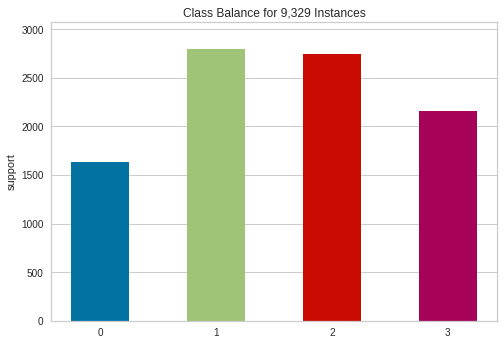

,ICD9_CODE,ttlCol
0,0,1634
1,3,2156
2,2,2742
3,1,2797


Oversampling data to match max class


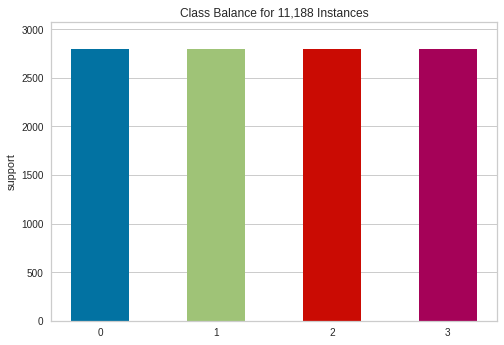

,ICD9_CODE,ttlCol
0,0,2797
1,1,2797
2,2,2797
3,3,2797



Processing data package has been completed

DataPackage summary
Attributes:
---> uniqueColumn: uuid
---> dataColumn: TEXT
---> targetColumn: ICD9_CODE
Data:
---> isOrigDataLoaded: True
---> isWorkingDataLoaded: True
---> isTrainDataLoaded: True
---> isTestDataLoaded: True

Original Data:
---> original data shape: (11662, 3)
Working Data:
---> working data shape: (11662, 102)

Process:
---> isProcessed: True
---> isCleaned: True
---> isStopWorded: True
---> isBalanced: True
---> isEncoded: True
---> isTrainTestSplit: True
---> isImportantFeaturesApplied: False
Experiment index[0]XGB depth:10 est:100 not yet created. Generating
Training model for XGB depth:10 est:100. <class 'xgboost.sklearn.XGBClassifier'>
Completed. Wall time[h:m:s]: 00:00:06
Predicting model for XGB depth:10 est:100. <class 'xgboost.sklearn.XGBClassifier'>
<class 'xgboost.sklearn.XGBClassifier'>
Supervised model being processed. Calling predictProba
Completed. Wall time[h:m:s]: 00:00:00

Model Stats:


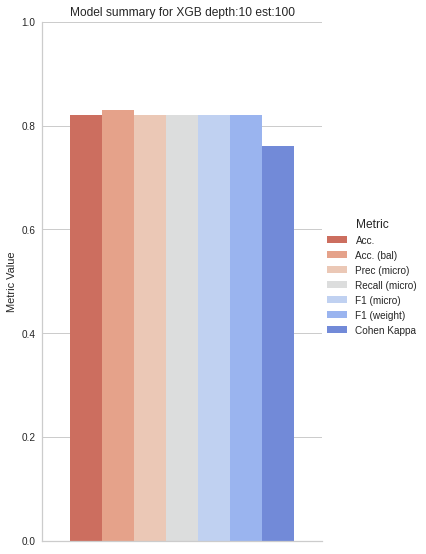

Experiment,Acc.,Acc. (bal),Prec (micro),Recall (micro),F1 (micro),F1 (weight),Cohen Kappa
XGB depth:10 est:100,0.82,0.83,0.82,0.82,0.82,0.82,0.76


  0%|          | 0/52 [00:00<?, ?it/s]

Feature Importance Summary:
---> Original feature count: 100
---> Returned feature count: 100
---> Removed feature count: 0
---> Return items above (including): 0.0015
Important features kept:
['abdomen', 'action', 'active', 'acute', 'alert', 'also', 'artery', 'assessment', 'attending', 'baby', 'benign', 'bili', 'blood', 'bowel', 'chest', 'clear', 'clip', 'cont', 'continue', 'continues', 'cpap', 'culture', 'current', 'disease', 'effusion', 'examination', 'failure', 'feed', 'feeding', 'first', 'fluid', 'full', 'given', 'good', 'heart', 'increased', 'infant', 'known', 'last', 'lastname', 'left', 'line', 'lung', 'meql', 'mgdl', 'mild', 'monitor', 'murmur', 'need', 'negative', 'neonatology', 'normal', 'note', 'noted', 'number', 'open', 'pain', 'patient', 'plan', 'prior', 'pulse', 'radiology', 'rate', 'reason', 'remains', 'renal', 'report', 'resp', 'respiratory', 'response', 'retraction', 'rhythm', 'right', 'seen', 'sepsis', 'shift', 'since', 'skin', 'small', 'soft', 'sound', 'spell', 'spit

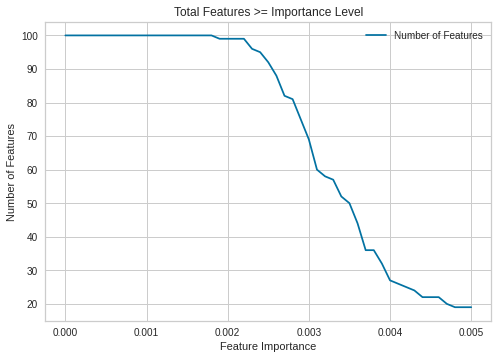

In [14]:
# Analyze model features for importance for feature trimming
myEM.analyzeModelFeatureImportance(experiment_index=0, #Which model to use as surrogate for feature importance
                                   startValue=0,
                                   upperValue=0.005,
                                   returnAbove=0.0015,
                                   process_package=True,
                                   num_cores=15,
                                   apply_features=False)

Experiment index[0]XGB depth:10 est:100 model already created


  0%|          | 0/102 [00:00<?, ?it/s]

Feature Importance Summary:
---> Original feature count: 100
---> Returned feature count: 50
---> Removed feature count: 50
---> Return items above (including): 0.0035
Important features kept:
['action', 'acute', 'artery', 'assessment', 'baby', 'bili', 'bowel', 'chest', 'clip', 'cpap', 'culture', 'current', 'disease', 'examination', 'failure', 'feed', 'fluid', 'good', 'heart', 'infant', 'left', 'line', 'meql', 'mgdl', 'mild', 'murmur', 'pain', 'prior', 'pulse', 'rate', 'remains', 'renal', 'resp', 'respiratory', 'response', 'rhythm', 'sepsis', 'shift', 'small', 'spit', 'stool', 'support', 'tablet', 'tolerated', 'tolerating', 'total', 'urine', 'valve', 'voiding', 'weight']
Filtering data for only important features
dataPackage features changed. Resetting state of experiment models to unprocessed
idx Processed       Method Experiment name               
  0     False   supervised XGB depth:10 est:100
  1     False   supervised XGB depth:20 est:200
  2     False   supervised XGB depth:25 e

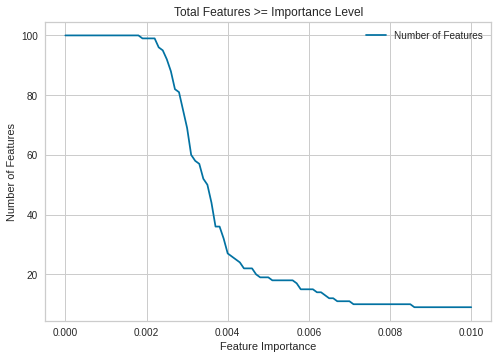

In [44]:
# Analyze model features for importance for feature trimming
myEM.analyzeModelFeatureImportance(experiment_index=0, #Which model to use as surrogate for feature importance
                                   startValue=0,
                                   upperValue=0.01,
                                   returnAbove=0.0035,
                                   process_package=True,
                                   num_cores=15,
                                   apply_features=True)

# ExperimentManager - run_experiment

In [45]:
myEM.list_experiments()

idx Processed       Method Experiment name               
  0     False   supervised XGB depth:10 est:100
  1     False   supervised XGB depth:20 est:200
  2     False   supervised XGB depth:25 est:200
  3     False   supervised RF depth:10 est:100
  4     False   supervised RF depth:20 est:200
  5     False   supervised RF depth:25 est:200
  6     False unsupervised KMeans n=4


---------------------------------------------------------------------------
Data package has already been processed


---------------------------------------------------------------------------
Processing experiment: [0] XGB depth:10 est:100

Training model for XGB depth:10 est:100. <class 'xgboost.sklearn.XGBClassifier'>
Completed. Wall time[h:m:s]: 00:00:03
Predicting model for XGB depth:10 est:100. <class 'xgboost.sklearn.XGBClassifier'>
<class 'xgboost.sklearn.XGBClassifier'>
Supervised model being processed. Calling predictProba
Completed. Wall time[h:m:s]: 00:00:00

Model Stats:


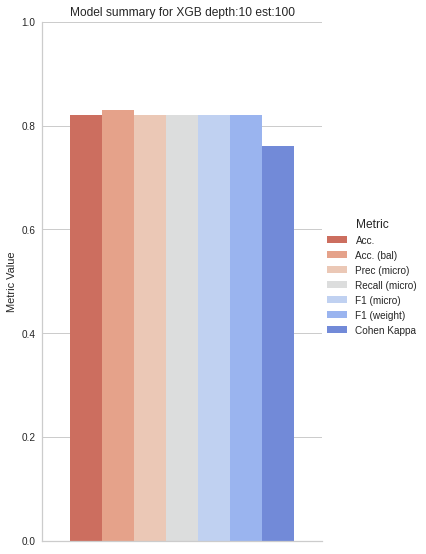

Experiment,Acc.,Acc. (bal),Prec (micro),Recall (micro),F1 (micro),F1 (weight),Cohen Kappa
XGB depth:10 est:100,0.82,0.83,0.82,0.82,0.82,0.82,0.76




Completed. Wall time[h:m:s]: 00:00:03


---------------------------------------------------------------------------
Processing experiment: [1] XGB depth:20 est:200

Training model for XGB depth:20 est:200. <class 'xgboost.sklearn.XGBClassifier'>
Completed. Wall time[h:m:s]: 00:00:10
Predicting model for XGB depth:20 est:200. <class 'xgboost.sklearn.XGBClassifier'>
<class 'xgboost.sklearn.XGBClassifier'>
Supervised model being processed. Calling predictProba
Completed. Wall time[h:m:s]: 00:00:00

Model Stats:


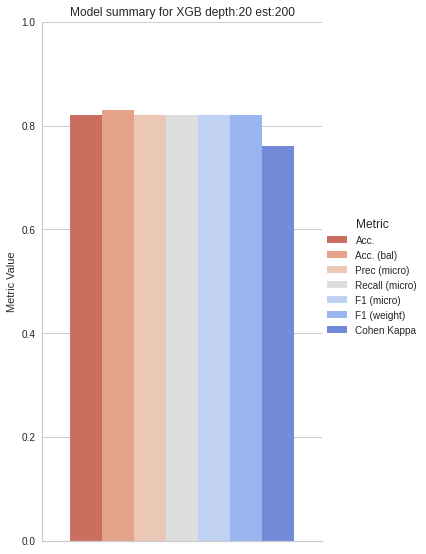

Experiment,Acc.,Acc. (bal),Prec (micro),Recall (micro),F1 (micro),F1 (weight),Cohen Kappa
XGB depth:20 est:200,0.82,0.83,0.82,0.82,0.82,0.82,0.76




Completed. Wall time[h:m:s]: 00:00:10


---------------------------------------------------------------------------
Processing experiment: [2] XGB depth:25 est:200

Training model for XGB depth:25 est:200. <class 'xgboost.sklearn.XGBClassifier'>
Completed. Wall time[h:m:s]: 00:01:24
Predicting model for XGB depth:25 est:200. <class 'xgboost.sklearn.XGBClassifier'>
<class 'xgboost.sklearn.XGBClassifier'>
Supervised model being processed. Calling predictProba
Completed. Wall time[h:m:s]: 00:00:00

Model Stats:


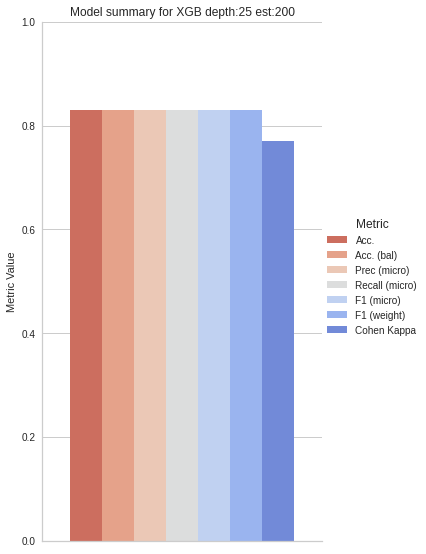

Experiment,Acc.,Acc. (bal),Prec (micro),Recall (micro),F1 (micro),F1 (weight),Cohen Kappa
XGB depth:25 est:200,0.83,0.83,0.83,0.83,0.83,0.83,0.77




Completed. Wall time[h:m:s]: 00:01:25


---------------------------------------------------------------------------
Processing experiment: [3] RF depth:10 est:100

Training model for RF depth:10 est:100. <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Completed. Wall time[h:m:s]: 00:00:00
Predicting model for RF depth:10 est:100. <class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Supervised model being processed. Calling predictProba
Completed. Wall time[h:m:s]: 00:00:00

Model Stats:


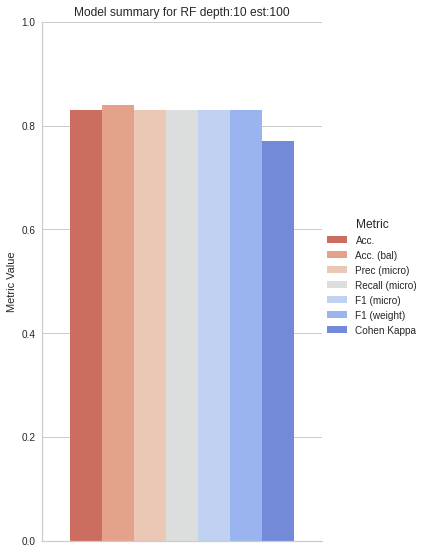

Experiment,Acc.,Acc. (bal),Prec (micro),Recall (micro),F1 (micro),F1 (weight),Cohen Kappa
RF depth:10 est:100,0.83,0.84,0.83,0.83,0.83,0.83,0.77




Completed. Wall time[h:m:s]: 00:00:01


---------------------------------------------------------------------------
Processing experiment: [4] RF depth:20 est:200

Training model for RF depth:20 est:200. <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Completed. Wall time[h:m:s]: 00:00:00
Predicting model for RF depth:20 est:200. <class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Supervised model being processed. Calling predictProba
Completed. Wall time[h:m:s]: 00:00:00

Model Stats:


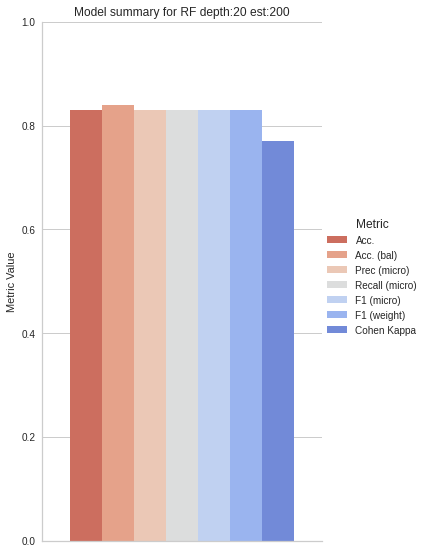

Experiment,Acc.,Acc. (bal),Prec (micro),Recall (micro),F1 (micro),F1 (weight),Cohen Kappa
RF depth:20 est:200,0.83,0.84,0.83,0.83,0.83,0.83,0.77




Completed. Wall time[h:m:s]: 00:00:01


---------------------------------------------------------------------------
Processing experiment: [5] RF depth:25 est:200

Training model for RF depth:25 est:200. <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Completed. Wall time[h:m:s]: 00:00:00
Predicting model for RF depth:25 est:200. <class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Supervised model being processed. Calling predictProba
Completed. Wall time[h:m:s]: 00:00:00

Model Stats:


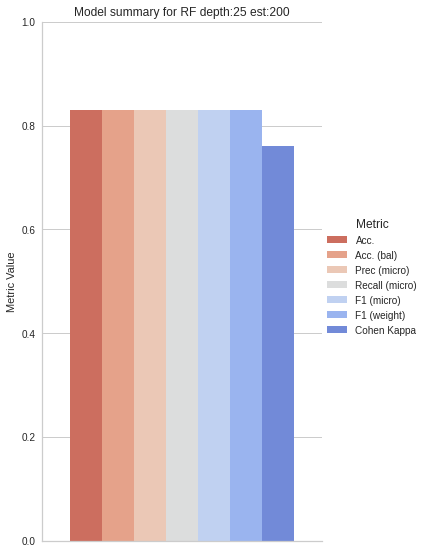

Experiment,Acc.,Acc. (bal),Prec (micro),Recall (micro),F1 (micro),F1 (weight),Cohen Kappa
RF depth:25 est:200,0.83,0.83,0.83,0.83,0.83,0.83,0.76




Completed. Wall time[h:m:s]: 00:00:01


---------------------------------------------------------------------------
Processing experiment: [6] KMeans n=4

Training model for KMeans n=4. <class 'sklearn.cluster._kmeans.KMeans'>
Completed. Wall time[h:m:s]: 00:00:01
Predicting model for KMeans n=4. <class 'sklearn.cluster._kmeans.KMeans'>
Unsupervised model being processed. no predict proba
Completed. Wall time[h:m:s]: 00:00:00

Model Stats:


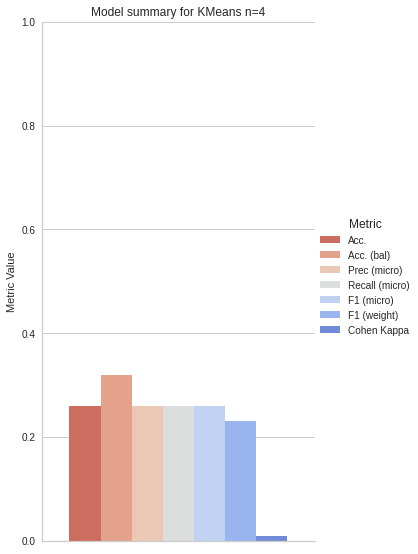

Experiment,Acc.,Acc. (bal),Prec (micro),Recall (micro),F1 (micro),F1 (weight),Cohen Kappa
KMeans n=4,0.26,0.32,0.26,0.26,0.26,0.23,0.01




Completed. Wall time[h:m:s]: 00:00:02


Processing complete. Displaying model comparison


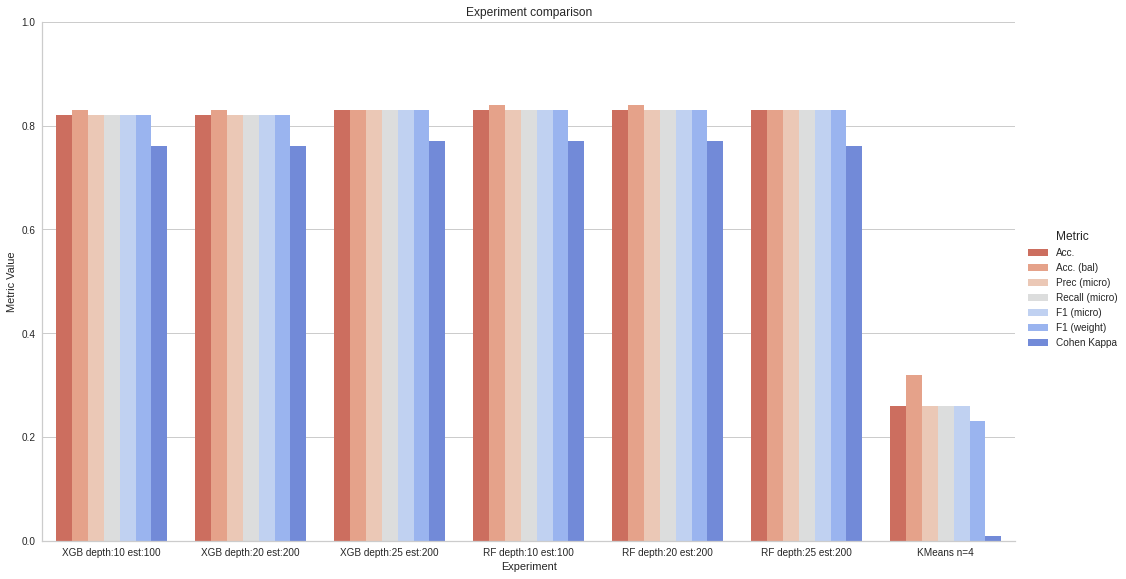

Experiment,Acc.,Acc. (bal),Prec (micro),Recall (micro),F1 (micro),F1 (weight),Cohen Kappa
XGB depth:10 est:100,0.82,0.83,0.82,0.82,0.82,0.82,0.76
XGB depth:20 est:200,0.82,0.83,0.82,0.82,0.82,0.82,0.76
XGB depth:25 est:200,0.83,0.83,0.83,0.83,0.83,0.83,0.77
RF depth:10 est:100,0.83,0.84,0.83,0.83,0.83,0.83,0.77
RF depth:20 est:200,0.83,0.84,0.83,0.83,0.83,0.83,0.77
RF depth:25 est:200,0.83,0.83,0.83,0.83,0.83,0.83,0.76
KMeans n=4,0.26,0.32,0.26,0.26,0.26,0.23,0.01



Processing experiments complete. Wall time[h:m:s]: 00:01:46


In [46]:
myEM.run_experiment(index=None, # index=None means process all experiements, 
                    num_cores=15 # num parallel processes to process text cleaning
                    )
                                # otherwise provide index of single experiment to run

# Create unsupervised mapping

In [47]:
# Which experiment index is the unsupervised
unsupervised_experiment=6

In [48]:
_ = myEM.experiments[unsupervised_experiment].get_unsupervised_mapping(showNumResults=5,
                                                 auto_mapping=True)


Current results of comparison between clusters and actuals
   y_test  y_pred  record_count
0       2       1           484
1       1       0           359
2       1       2           341
3       0       0           314
4       3       3           286
Unique values in y_test: 4
Unique values in y_pred: 4
Unique values in y_test and y_pred: 4
Number of rows/combinations: 10

All mappings appear in predictions. All good
Auto mapping the results
Mapping predicted to actual: {1: 2, 0: 1, 3: 3, 2: 0}


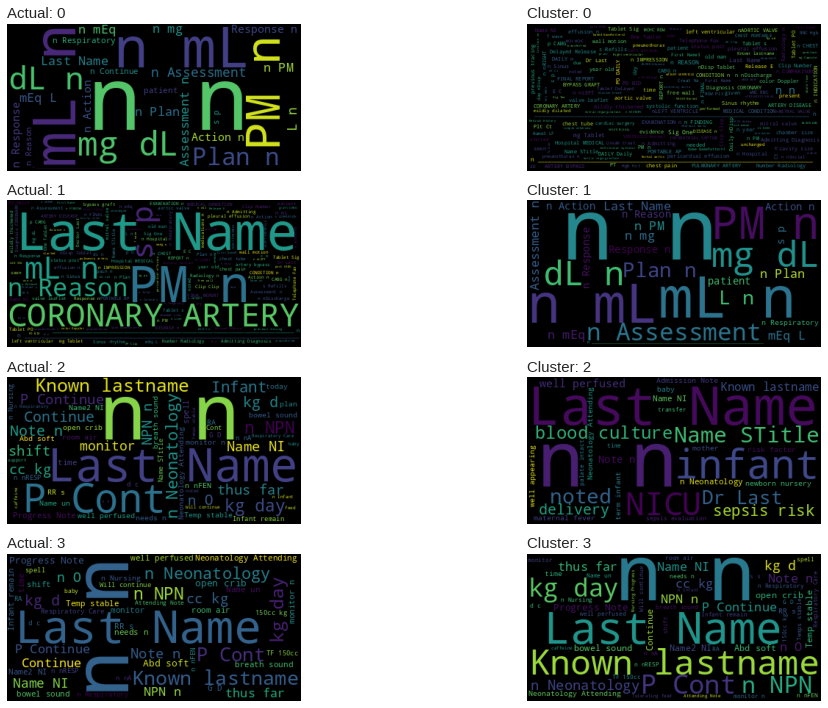

In [49]:
myEM.experiments[unsupervised_experiment].show_cluster_mapping_cloud()

Processing complete. Displaying model comparison


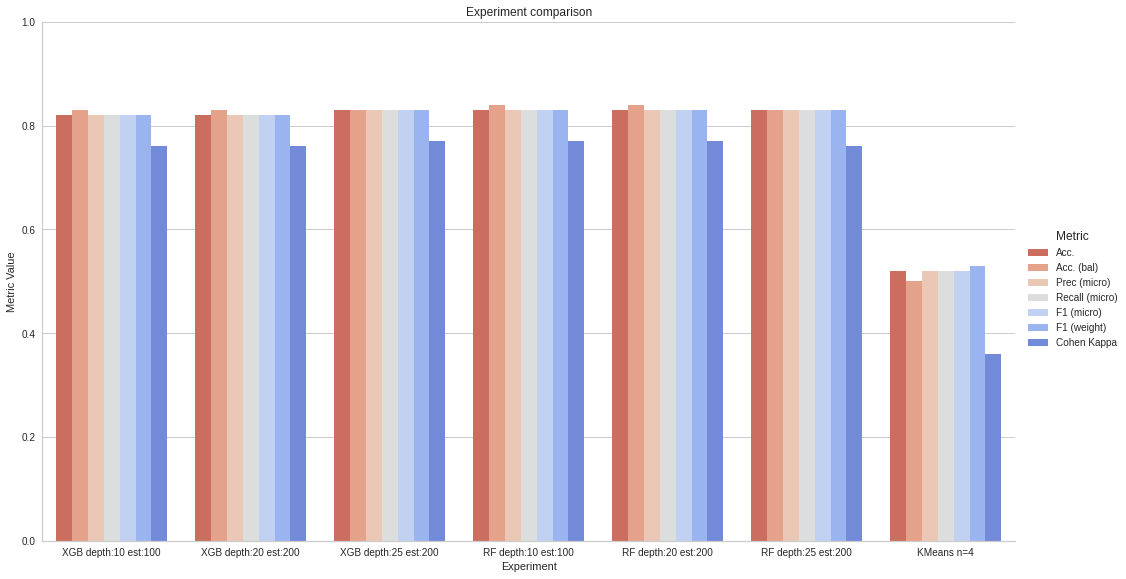

Experiment,Acc.,Acc. (bal),Prec (micro),Recall (micro),F1 (micro),F1 (weight),Cohen Kappa
XGB depth:10 est:100,0.82,0.83,0.82,0.82,0.82,0.82,0.76
XGB depth:20 est:200,0.82,0.83,0.82,0.82,0.82,0.82,0.76
XGB depth:25 est:200,0.83,0.83,0.83,0.83,0.83,0.83,0.77
RF depth:10 est:100,0.83,0.84,0.83,0.83,0.83,0.83,0.77
RF depth:20 est:200,0.83,0.84,0.83,0.83,0.83,0.83,0.77
RF depth:25 est:200,0.83,0.83,0.83,0.83,0.83,0.83,0.76
KMeans n=4,0.52,0.50,0.52,0.52,0.52,0.53,0.36


In [50]:
_ = myEM.show_model_comparison()

# Show representative experiment Summary


Model Stats:


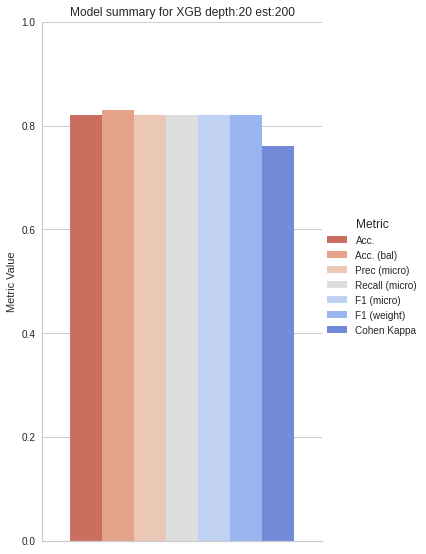

Experiment,Acc.,Acc. (bal),Prec (micro),Recall (micro),F1 (micro),F1 (weight),Cohen Kappa
XGB depth:20 est:200,0.82,0.83,0.82,0.82,0.82,0.82,0.76



              precision    recall  f1-score   support

           0       0.99      0.99      0.99       409
           1       0.99      0.99      0.99       700
           2       0.70      0.70      0.70       685
           3       0.62      0.62      0.62       539

    accuracy                           0.82      2333
   macro avg       0.83      0.83      0.83      2333
weighted avg       0.82      0.82      0.82      2333



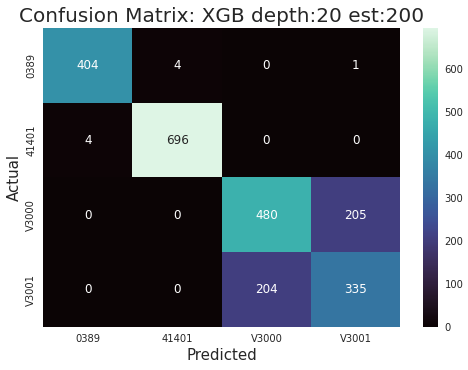

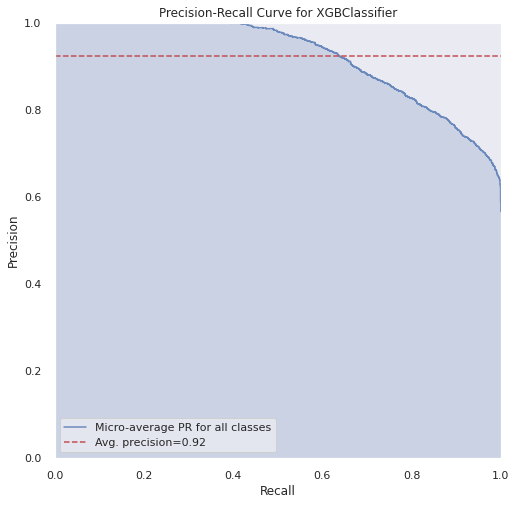

Model Learning curve has not yet been calculated. Calculating now


<Figure size 576x576 with 0 Axes>

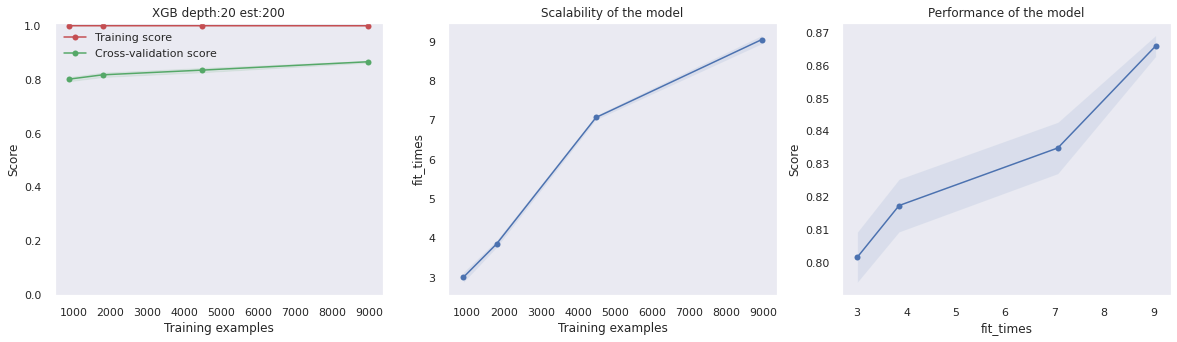

Model ROCAUC not calculated. Calculating now


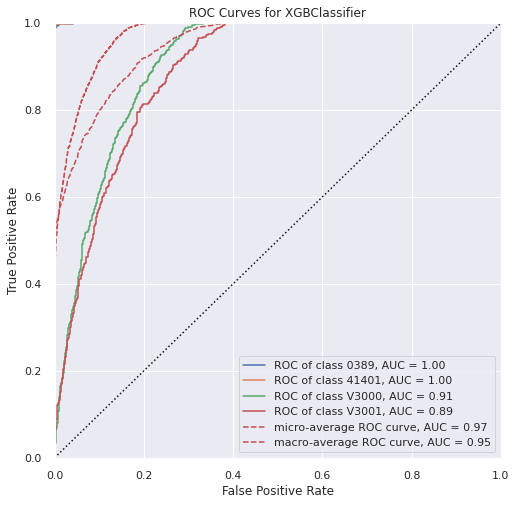

  0%|          | 0/101 [00:00<?, ?it/s]

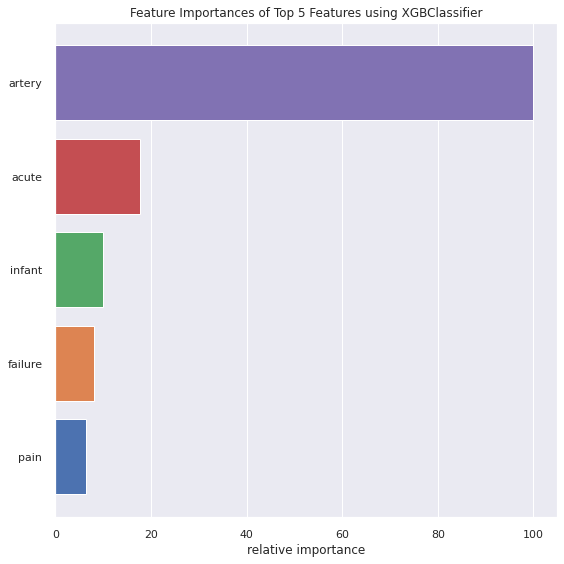

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


<Figure size 576x576 with 0 Axes>

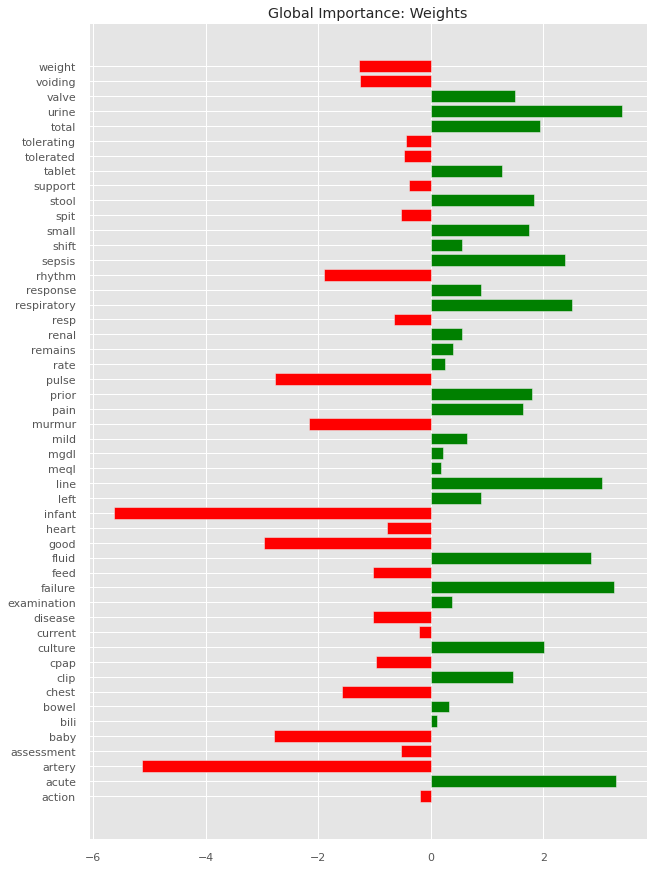

predicted [3]
actual 2


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


<Figure size 576x576 with 0 Axes>

In [51]:
representative_experiment = 1
myEM.experiments[representative_experiment].showFullModelReport()

# Add additional models

In [52]:
# Create the optimizer and parameters for processing the CNN model

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

tp = TensorParms(loss='sparse_categorical_crossentropy',
                 optimizer=opt,
                 metrics=['accuracy'],
                 validation_split=0.25,
                 epochs=25,
                 batch_size=32,
                 shuffle=True,
                 verbose=1)

# Num features to process
input_size = len(myEM.data_package.dataFeatures)

# Num classes
output_size = NUM_UNIQUE_ICD9_CODES

In [53]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from keras.layers import BatchNormalization

untrained_CNN1 = Sequential()
untrained_CNN1.add(Conv1D(32, 3, activation='relu', input_shape = (input_size,1)))
untrained_CNN1.add(BatchNormalization()) 
untrained_CNN1.add(Dropout(0.5)) 
untrained_CNN1.add(MaxPooling1D(2))
untrained_CNN1.add(Flatten())
untrained_CNN1.add(Dense(100, activation='relu'))
untrained_CNN1.add(Dense(output_size, activation='softmax'))


myEM.add_experiment(experiment_name=f'CNN input:{input_size} classes:{output_size}',
                    experiment_method='supervised',
                    untrained_model=untrained_CNN1)

2022-10-07 14:36:06.730236: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 14:36:06.730546: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 14:36:06.750721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 14:36:06.750956: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 14:36:06.751270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S


DataExperiment summary:
---> projectName: mimiciii_LL
---> experimentName: CNN input:50 classes:4
---> experimentMethod: supervised
---> isDataPackageLoaded: True
---> isProcessed: False
---> isModelLoaded: False
---> isModelPredicted: False
---> isLearningCurveCreated: False
---> isUntrainedModelLoaded: True


2022-10-07 14:36:06.752827: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-07 14:36:06.811829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 14:36:06.812078: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 14:36:06.812245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

INFO:tensorflow:Assets written to: ram://0def99a3-1b98-4d8e-9798-d57b0e7a5acb/assets

<class 'keras.engine.sequential.Sequential'>


In [54]:
myEM.list_experiments()


idx Processed       Method Experiment name               
  0      True   supervised XGB depth:10 est:100
  1      True   supervised XGB depth:20 est:200
  2      True   supervised XGB depth:25 est:200
  3      True   supervised RF depth:10 est:100
  4      True   supervised RF depth:20 est:200
  5      True   supervised RF depth:25 est:200
  6      True unsupervised KMeans n=4
  7     False   supervised CNN input:50 classes:4


---------------------------------------------------------------------------
Data package has already been processed

Processing experiment: CNN input:50 classes:4
Training model for CNN input:50 classes:4. <class 'keras.engine.sequential.Sequential'>
Keras model detected. compiling and training
INFO:tensorflow:Assets written to: ram://c0dbe2f5-6a49-4856-8764-18c9f8eb0639/assets


2022-10-07 14:36:09.436408: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8500


Completed. Wall time[h:m:s]: 00:00:30
Predicting model for CNN input:50 classes:4. <class 'keras.engine.sequential.Sequential'>
<class 'keras.engine.sequential.Sequential'>
Unsupervised model being processed. no predict proba
Completed. Wall time[h:m:s]: 00:00:00

Model Stats:


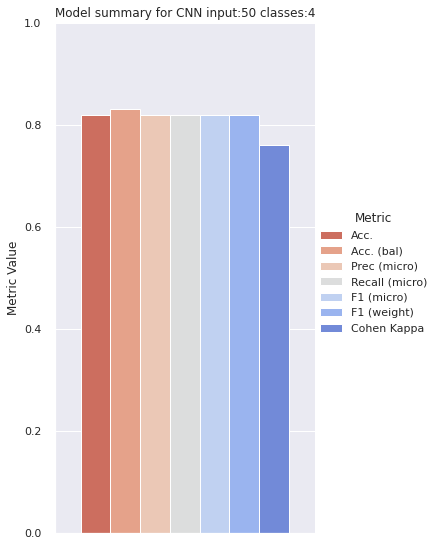

Experiment,Acc.,Acc. (bal),Prec (micro),Recall (micro),F1 (micro),F1 (weight),Cohen Kappa
CNN input:50 classes:4,0.82,0.83,0.82,0.82,0.82,0.82,0.76




Processing complete. Displaying model comparison


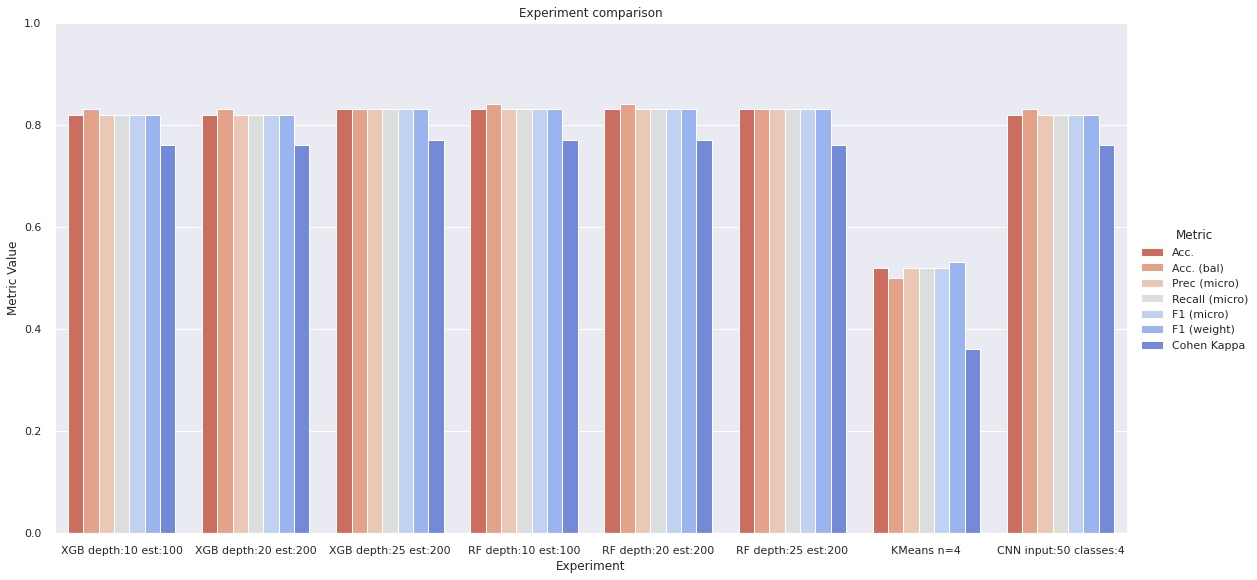

Experiment,Acc.,Acc. (bal),Prec (micro),Recall (micro),F1 (micro),F1 (weight),Cohen Kappa
XGB depth:10 est:100,0.82,0.83,0.82,0.82,0.82,0.82,0.76
XGB depth:20 est:200,0.82,0.83,0.82,0.82,0.82,0.82,0.76
XGB depth:25 est:200,0.83,0.83,0.83,0.83,0.83,0.83,0.77
RF depth:10 est:100,0.83,0.84,0.83,0.83,0.83,0.83,0.77
RF depth:20 est:200,0.83,0.84,0.83,0.83,0.83,0.83,0.77
RF depth:25 est:200,0.83,0.83,0.83,0.83,0.83,0.83,0.76
KMeans n=4,0.52,0.50,0.52,0.52,0.52,0.53,0.36
CNN input:50 classes:4,0.82,0.83,0.82,0.82,0.82,0.82,0.76



Processing experiments complete. Wall time[h:m:s]: 00:00:30


In [55]:
myEM.run_experiment(index=7,
                    num_cores=15)

# Show final metric comparison

Processing complete. Displaying model comparison


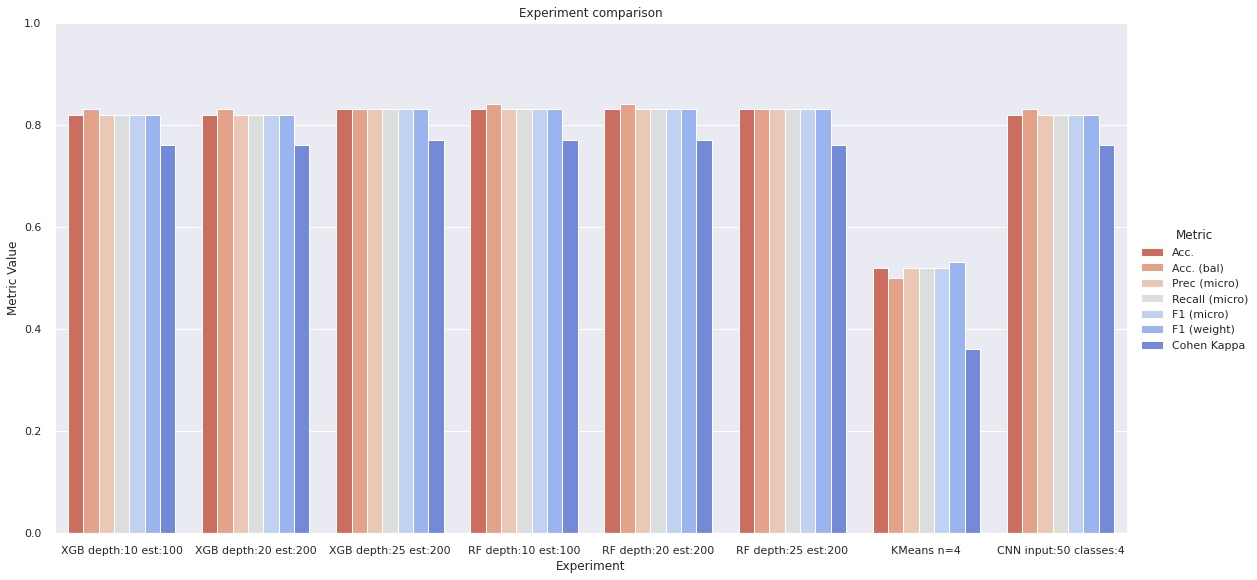

Experiment,Acc.,Acc. (bal),Prec (micro),Recall (micro),F1 (micro),F1 (weight),Cohen Kappa
XGB depth:10 est:100,0.82,0.83,0.82,0.82,0.82,0.82,0.76
XGB depth:20 est:200,0.82,0.83,0.82,0.82,0.82,0.82,0.76
XGB depth:25 est:200,0.83,0.83,0.83,0.83,0.83,0.83,0.77
RF depth:10 est:100,0.83,0.84,0.83,0.83,0.83,0.83,0.77
RF depth:20 est:200,0.83,0.84,0.83,0.83,0.83,0.83,0.77
RF depth:25 est:200,0.83,0.83,0.83,0.83,0.83,0.83,0.76
KMeans n=4,0.52,0.50,0.52,0.52,0.52,0.53,0.36
CNN input:50 classes:4,0.82,0.83,0.82,0.82,0.82,0.82,0.76


In [56]:
_ = myEM.show_model_comparison()

# Scratchpad